#### Instala as dependências da aplicação
###### Baseado em: https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/

In [1]:
import sys
# !{sys.executable} -m pip install pandas plotly seaborn

#### Importa as dependências utilizadas

In [2]:
import math
import pandas as pd
import seaborn as sns
import plotly.express as plx
from pyspark.sql import SparkSession
from IPython.display import display
import pyspark.sql.types as pyt
import pyspark.sql.functions as pyf
from matplotlib import pyplot as plt

#### Inicializa uma seção do Apache Spark

In [3]:
spark = SparkSession.builder.appName("Analysis") \
    .master('local[*]') \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/18 10:50:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Define as informações de acesso para a planilha de dados

In [4]:
# OKR
OKR_SHEET_FILE_PATH = "./Case2/dados/dados_okr.xlsx"
OBJECTIVES_SHEET_NAME = "objectives"
KEY_RESULTS_SHEET_NAME = "key_results"

# Values
VALUES_SHEET_FILE_PATH = "./Case2/dados/dados_values.xlsx"
QUESTIONS_SHEET_NAME =  "keyBehaviors"
SUBJECTS_SHEET_NAME = "subjects"
CATEGORIES_SHEET_NAME = "categories"

### Objetivos e Resultados Chaves

#### Lê todas as planilhas de dados dos OKR's

In [5]:
df_objectives = spark.createDataFrame(
    pd.io.excel.read_excel(OKR_SHEET_FILE_PATH, sheet_name=OBJECTIVES_SHEET_NAME)
)

df_key_results = spark.createDataFrame(
    pd.io.excel.read_excel(OKR_SHEET_FILE_PATH, sheet_name=KEY_RESULTS_SHEET_NAME)
)

### Objetivos

##### Trecho do dataframe de objetivos

In [6]:
df_objectives.show()

+---+-------+---------+----------+---------+------------------+-------------------+
| id|user_id|parent_id|section_id|period_id|          progress|         created_at|
+---+-------+---------+----------+---------+------------------+-------------------+
| 10|     23|      NaN|       1.0|        1|0.8226190476190476|2018-11-13 14:14:05|
| 13|      8|     10.0|       3.0|        1|0.8333333333333333|2018-11-16 17:55:49|
| 18|     30|     10.0|      15.0|        1|               1.0|2018-11-21 09:54:09|
| 19|     78|     10.0|      21.0|        1|               1.0|2018-11-21 10:06:00|
| 20|     15|     10.0|       6.0|        1|               0.5|2018-11-21 10:39:07|
| 21|     54|     10.0|       5.0|        1|               1.0|2018-11-21 17:18:18|
| 22|     54|     10.0|       4.0|        1|               0.0|2018-11-21 17:26:12|
| 23|     33|     10.0|      16.0|        1|               0.5|2018-11-22 08:58:56|
| 26|     78|     40.0|      21.0|        3|0.6532155092592592|2019-01-08 08

##### Quantidade de linhas no dataframe de objetivos

In [7]:
df_objectives.count()

584

##### Descreve os dados do dataframe de objetivos

In [8]:
df_objectives.describe().show()

+-------+------------------+------------------+---------+----------+------------------+------------------+-------------------+
|summary|                id|           user_id|parent_id|section_id|         period_id|          progress|         created_at|
+-------+------------------+------------------+---------+----------+------------------+------------------+-------------------+
|  count|               584|               584|      584|       584|               584|               584|                584|
|   mean|483.61301369863014|149.21575342465752|      NaN|       NaN|14.121575342465754|0.8286730906774055|               null|
| stddev|  269.157132211022| 107.3847925889079|      NaN|       NaN| 7.040481835642982|  8.70948171459407|               null|
|    min|                10|                 3|     10.0|       1.0|                 1|               0.0|2018-11-13 14:14:05|
|    max|               921|               493|      NaN|       NaN|                25| 210.7320688732786|2021-

#### Eliminando amostras outliers.
O progresso máximo é 210.73, como campo é um valor percentual, claramente existe algum outlier

In [9]:
df_objectives.orderBy(pyf.col('progress').desc()).show(n=10)

+---+-------+---------+----------+---------+-----------------+-------------------+
| id|user_id|parent_id|section_id|period_id|         progress|         created_at|
+---+-------+---------+----------+---------+-----------------+-------------------+
|686|    106|    651.0|       NaN|       16|210.7320688732786|2021-03-15 15:27:31|
|666|    259|    651.0|       NaN|       16|          2.83925|2021-02-23 16:13:45|
|693|    256|    652.0|       NaN|       16|2.275941176470588|2021-03-15 15:44:08|
|694|    263|    652.0|       NaN|       16|1.683292647058823|2021-03-15 15:46:04|
|493|    160|    478.0|       NaN|       14|1.600142857142857|2020-10-23 09:19:27|
|648|    204|    651.0|       NaN|       16|         1.548125|2021-02-18 14:51:50|
|688|    246|    652.0|       NaN|       16|              1.5|2021-03-15 15:31:33|
|482|     68|    478.0|       NaN|       14|1.498172077922078|2020-10-23 08:58:28|
|687|    160|    652.0|       NaN|       16|1.350367647058824|2021-03-15 15:29:10|
|481

##### O objetivo de ID igual a 686 é considerado um outilier pois possui uma performance totalmente desproporcional a realidade e por isso é removido do dataframe

In [10]:
df_objectives = df_objectives.where('id != 686')

##### Quantidade média de objetivos por colaborador

In [11]:
df_objectives.groupby('user_id') \
    .count() \
    .agg(pyf.mean('count')) \
    .show()

+-----------------+
|       avg(count)|
+-----------------+
|3.429411764705882|
+-----------------+



#### Estatísticas básicas da coluna de progresso

In [12]:
df_objectives.agg(
        pyf.count('progress').alias('count'),
        pyf.min("progress").alias('min'),
        pyf.max("progress").alias('max'),
        (pyf.max("progress") - pyf.min("progress")).alias("range"),
        pyf.avg("progress").alias('mean'),
        pyf.variance("progress").alias('variance'),
        pyf.stddev("progress").alias('std')
    ) \
    .show()

+-----+---+-------+-------+------------------+-------------------+-------------------+
|count|min|    max|  range|              mean|           variance|                std|
+-----+---+-------+-------+------------------+-------------------+-------------------+
|  583|0.0|2.83925|2.83925|0.4686329606900963|0.15205775878518052|0.38994584083585315|
+-----+---+-------+-------+------------------+-------------------+-------------------+



### Resultados Chaves

##### Trecho do dataframe

In [13]:
df_key_results.show()

+---+------------+-------+------------------+-------------------+
| id|objective_id|user_id|          progress|         created_at|
+---+------------+-------+------------------+-------------------+
| 22|          10|     78|               1.0|2018-11-16 09:56:11|
| 27|          10|      8|               0.8|2018-11-19 10:04:57|
| 28|          10|      8|               0.8|2018-11-19 10:11:42|
| 23|          13|      8|0.6666666666666666|2018-11-16 17:56:28|
| 24|          13|      8|               1.0|2018-11-16 17:56:58|
| 29|          18|     30|               1.0|2018-11-21 09:56:32|
| 30|          18|     30|               1.0|2018-11-21 10:01:46|
| 31|          18|     30|               1.0|2018-11-21 10:04:23|
| 32|          19|     77|               1.0|2018-11-21 10:11:54|
| 33|          19|     77|               1.0|2018-11-21 10:13:10|
| 38|          20|     15|               1.0|2018-11-22 09:06:50|
| 39|          20|     15|               0.0|2018-11-22 09:07:14|
| 34|     

##### Quantidade de linhas no dataframe de Resultados Chaves

In [14]:
df_key_results.count()

1762

##### Descreve os dados do dataframe de Resultados Chaves

In [15]:
df_key_results.describe().show()

+-------+------------------+------------------+------------------+------------------+-------------------+
|summary|                id|      objective_id|           user_id|          progress|         created_at|
+-------+------------------+------------------+------------------+------------------+-------------------+
|  count|              1762|              1762|              1762|              1762|               1762|
|   mean|1313.2213393870602|448.48637911464243|135.97843359818387|0.9651780235640951|               null|
| stddev| 747.7374449536587|259.19779069975425| 96.46154541958202|15.024229551351732|               null|
|    min|                22|                10|                 3|               0.0|2018-11-16 09:56:11|
|    max|              2555|               921|               461| 629.6666666666429|2021-12-16 09:40:42|
+-------+------------------+------------------+------------------+------------------+-------------------+



#### Eliminando outliers
O valor máximo do campo progress é 629.66 e como esse campo possui valores percentuais, fica evidente que existe algum outlier

In [16]:
df_key_results.orderBy(pyf.col('progress').desc()).show(n=10)

+----+------------+-------+-----------------+-------------------+
|  id|objective_id|user_id|         progress|         created_at|
+----+------------+-------+-----------------+-------------------+
|1978|         686|    106|629.6666666666429|2021-03-15 15:28:47|
| 349|         132|     31| 37.9999999999801|2019-04-12 11:41:48|
|1997|         693|    256|             8.25|2021-03-15 15:45:24|
|2349|         780|    216|7.339417475728156|2021-07-20 11:12:43|
|1483|         502|    123|              5.0|2020-10-29 10:46:36|
|1482|         502|     13|              5.0|2020-10-29 10:46:36|
| 246|         103|    111|4.993421052631581|2019-02-22 16:42:02|
|2000|         694|    263|              3.4|2021-03-15 15:47:43|
| 875|         266|    156|3.328026315789474|2020-05-13 09:48:51|
|1359|         481|    106|3.214285714285714|2020-10-23 09:29:25|
+----+------------+-------+-----------------+-------------------+
only showing top 10 rows



O Resultados chaves de ID igual a 349 e 1978 são os outliers do dataframe

In [17]:
df_key_results = df_key_results.where('id not in (349, 1978)')

#### Estatísticas básicas baseada na coluna de progresso

In [18]:
df_key_results.agg(
        pyf.count('progress').alias('count'),
        pyf.min("progress").alias('min'),
        pyf.max("progress").alias('max'),
        (pyf.max("progress") - pyf.min("progress")).alias("range"),
        pyf.mean("progress").alias('mean'),
        pyf.variance("progress").alias('variance'),
        pyf.stddev("progress").alias('std')
    ) \
    .show()

+-----+---+----+-----+-----------------+------------------+------------------+
|count|min| max|range|             mean|          variance|               std|
+-----+---+----+-----+-----------------+------------------+------------------+
| 1760|0.0|8.25| 8.25|0.586918756166655|0.3508358386809182|0.5923139696823959|
+-----+---+----+-----+-----------------+------------------+------------------+



##### Quantidade média de Resultados Chaves por colaborador

In [19]:
df_key_results.groupby('user_id') \
    .count() \
    .agg(pyf.mean('count')) \
    .show()

+-----------------+
|       avg(count)|
+-----------------+
|8.073394495412844|
+-----------------+



##### Quantidade média de Resultados Chaves por Objetivo

In [20]:
df_key_results.groupby('objective_id') \
    .count() \
    .agg(pyf.mean('count')) \
    .show()

+----------------+
|      avg(count)|
+----------------+
|4.02745995423341|
+----------------+



### Competências

In [21]:
df_questions = spark.createDataFrame(
    pd.io.excel.read_excel(VALUES_SHEET_FILE_PATH, sheet_name=QUESTIONS_SHEET_NAME)
)

df_subjects = spark.createDataFrame(
    pd.io.excel.read_excel(VALUES_SHEET_FILE_PATH, sheet_name=SUBJECTS_SHEET_NAME)
)

df_categories = spark.createDataFrame(
    pd.io.excel.read_excel(VALUES_SHEET_FILE_PATH, sheet_name=CATEGORIES_SHEET_NAME)
)

##### Questões

##### Mostra um trecho do dataframe

In [22]:
df_questions.show()

+-------+----------------+-----------+--------+---------------+--------------------+-------------------+----------+------------+----------+
|user_id|questionnaire_id|category_id|value_id|key_behavior_id|  key_behavior_title|              score|self_score|leader_score|peer_score|
+-------+----------------+-----------+--------+---------------+--------------------+-------------------+----------+------------+----------+
|     13|              33|          1|       4|             11|Compreende e Real...| 0.5999800000000001|       0.4|         0.6|       NaN|
|     13|              33|          1|       4|             12|Planeja antes de ...| 0.5999800000000001|       0.4|         0.6|       NaN|
|     13|              33|          1|       4|             13|Busca por soluçõe...|0.40002000000000004|       0.6|         0.4|       NaN|
|     13|              33|          1|       5|             16|Atende com excelê...|                0.6|       0.6|         0.6|       NaN|
|     13|           

##### Descreve os dados do dataframe

In [23]:
df_questions.describe().show()

+-------+------------------+------------------+------------------+------------------+-----------------+--------------------+-------------------+----------+------------+----------+
|summary|           user_id|  questionnaire_id|       category_id|          value_id|  key_behavior_id|  key_behavior_title|              score|self_score|leader_score|peer_score|
+-------+------------------+------------------+------------------+------------------+-----------------+--------------------+-------------------+----------+------------+----------+
|  count|             16140|             16140|             16140|             16140|            16140|               16140|              16140|     16140|       16140|     16140|
|   mean| 191.4193308550186| 66.93085501858737|3.3654275092936805|17.200557620817843|68.41629491945477|                null|  0.644890246798834|       NaN|         NaN|       NaN|
| stddev|123.07985555663619|21.662804123277095|2.3204827563362884|10.463689751156833|38.981333074949

#### Quantidade de linhas no dataframe

In [24]:
df_questions.count()

16140

#### Quantidade de questões distintas avaliadas

In [25]:
df_questions.select(pyf.countDistinct("key_behavior_id").alias("count")).show()

+-----+
|count|
+-----+
|  111|
+-----+



In [26]:
df_questions \
    .groupBy('key_behavior_id') \
    .agg(
        pyf.first('key_behavior_title').alias('key_behavior_title'),
        pyf.count('score').alias('count'),
        pyf.min("score").alias('min'),
        pyf.max("score").alias('max'),
        (pyf.max("score") - pyf.min("score")).alias("range"),
        pyf.mean("score").alias('mean'),
        pyf.variance("score").alias('variance'),
        pyf.stddev("score").alias('std')
    ) \
    .show(n=999)


+---------------+--------------------+-----+-------------------+------------------+------------------+------------------+--------------------+-------------------+
|key_behavior_id|  key_behavior_title|count|                min|               max|             range|              mean|            variance|                std|
+---------------+--------------------+-----+-------------------+------------------+------------------+------------------+--------------------+-------------------+
|             11|Compreende e Real...|  391|                0.0|               1.0|               1.0|0.6122764705882354| 0.03164358904494722|0.17788644986324062|
|             12|Planeja antes de ...|  391|                0.0|               1.0|               1.0|0.6071621483375961| 0.03564042856768052| 0.1887867277317993|
|             13|Busca por soluçõe...|  391|                0.0|               1.0|               1.0|0.5956525319693096|0.037339430598444495| 0.1932341341441633|
|             16|Atend

#### Assuntos:

##### Mostra um trecho do dataframe

In [27]:
df_subjects.show()

+-------+----------------+-----------+--------+--------------------+-------------------+------------------+------------------+----------+
|user_id|questionnaire_id|category_id|value_id|         value_title|              score|        self_score|      leader_score|peer_score|
+-------+----------------+-----------+--------+--------------------+-------------------+------------------+------------------+----------+
|     13|              33|          1|       4|Pensamento Estrat...| 0.5333266666666667|0.4666666666666666|0.5333333333333333|       NaN|
|     13|              33|          1|       5|Foco no Cliente (...|            0.73332|               0.6|0.7333333333333334|       NaN|
|     13|              33|          1|       6|Orientação para R...|               0.52|              0.52|0.5199999999999999|       NaN|
|     13|              33|          1|       8|Liderança (Líder ...|               0.55|0.5499999999999999|              0.55|       NaN|
|     13|              33|        

##### Descreve os dados do dataframe

In [28]:
df_subjects.describe().show()

+-------+------------------+------------------+------------------+------------------+--------------------+-------------------+----------+------------+----------+
|summary|           user_id|  questionnaire_id|       category_id|          value_id|         value_title|              score|self_score|leader_score|peer_score|
+-------+------------------+------------------+------------------+------------------+--------------------+-------------------+----------+------------+----------+
|  count|              5423|              5423|              5423|              5423|                5423|               5423|      5423|        5423|      5423|
|   mean| 183.7106767471879| 64.71491794209847|3.5620505255393695|17.238982113221464|                null| 0.6488640842063091|       NaN|         NaN|       NaN|
| stddev|120.70551475891996|21.785291024958564|2.1984229449500994|10.256865872435487|                null|0.16903376451114444|       NaN|         NaN|       NaN|
|    min|                13|

##### Quantidade de linhas no dataframe

In [29]:
df_subjects.count()

5423

##### Quantidade de assuntos avaliados

In [30]:
df_subjects.select(pyf.countDistinct("value_id").alias("count")).show()

+-----+
|count|
+-----+
|   37|
+-----+



##### Estatísticas básicas de cada assunto baseado na nota final

In [31]:
df_subjects \
    .groupBy('value_id') \
    .agg(
        pyf.first('value_title').alias('value_title'),
        pyf.count('score').alias('count'),
        pyf.min("score").alias('min'),
        pyf.max("score").alias('max'),
        (pyf.max("score") - pyf.min("score")).alias("range"),
        pyf.mean("score").alias('mean'),
        pyf.variance("score").alias('variance'),
        pyf.stddev("score").alias('std')
    ) \
    .show(n=999, truncate=False)


+--------+---------------------------------------------+-----+-------------------+------------------+------------------+------------------+--------------------+-------------------+
|value_id|value_title                                  |count|min                |max               |range             |mean              |variance            |std                |
+--------+---------------------------------------------+-----+-------------------+------------------+------------------+------------------+--------------------+-------------------+
|4       |Pensamento Estratégico (Líder de Si)         |391  |0.0                |1.0               |1.0               |0.6050303836317137|0.028547026969396615|0.16895865461525378|
|5       |Foco no Cliente (Líder de Si)                |391  |0.0                |1.0               |1.0               |0.6280485933503838|0.02967553726021002 |0.17226589116888466|
|6       |Orientação para Resultados (Líder de Si)     |391  |0.0                |0.96         

#### Categorias

##### Mostra um trecho do dataframe

In [32]:
df_categories.show()

+-------+----------------+-----------+--------------+-------------------+-------------------+-------------------+----------+
|user_id|questionnaire_id|category_id|category_title|              score|         self_score|       leader_score|peer_score|
+-------+----------------+-----------+--------------+-------------------+-------------------+-------------------+----------+
|     13|              33|          1|   Lider de Si| 0.5606626666666668| 0.5206666666666667| 0.5606666666666668|       NaN|
|     14|              33|          1|   Lider de Si|          0.5326864| 0.7300000000000001| 0.5326666666666667|       NaN|
|     16|              33|          1|   Lider de Si| 0.6006971333333333| 0.9053333333333333| 0.6006666666666667|       NaN|
|     17|              33|          1|   Lider de Si| 0.5893446666666666| 0.7026666666666668| 0.5893333333333334|       NaN|
|     21|              33|          1|   Lider de Si| 0.6133506666666666| 0.7866666666666666| 0.6133333333333333|       NaN|


##### Descreve os dados do dataframe

In [33]:
df_categories.describe().show()

+-------+------------------+------------------+------------------+------------------+-------------------+----------+-------------------+------------------+
|summary|           user_id|  questionnaire_id|       category_id|    category_title|              score|self_score|       leader_score|        peer_score|
+-------+------------------+------------------+------------------+------------------+-------------------+----------+-------------------+------------------+
|  count|              1053|              1053|              1053|              1053|               1053|      1053|               1053|              1053|
|   mean|185.05982905982907| 65.18328584995251|  3.52991452991453|              null| 0.6484334854459669|       NaN|                NaN|               NaN|
| stddev|121.33412855285927|21.799414515609016|2.2053141168333936|              null|0.15143183585929476|       NaN|                NaN|               NaN|
|    min|                13|                33|                 

##### Quantidade de linhas no dataframe de categorias

In [34]:
df_categories.count()

1053

##### Quantidade de categorias

In [35]:
df_categories.select(pyf.countDistinct("category_id").alias("count")).show()

+-----+
|count|
+-----+
|    7|
+-----+



##### Estatísticas básicas de cada categoria baseada na nota final

In [36]:
df_categories \
    .groupBy('category_id') \
    .agg(
        pyf.first('category_title').alias('category_title'),
        pyf.count('score').alias('count'),
        pyf.min("score").alias('min'),
        pyf.max("score").alias('max'),
        (pyf.max("score") - pyf.min("score")).alias("range"),
        pyf.mean("score").alias('mean'),
        pyf.variance("score").alias('variance'),
        pyf.stddev("score").alias('std')
    ) \
    .show(n=999)

+-----------+------------------+-----+-------------------+------------------+------------------+------------------+--------------------+-------------------+
|category_id|    category_title|count|                min|               max|             range|              mean|            variance|                std|
+-----------+------------------+-----+-------------------+------------------+------------------+------------------+--------------------+-------------------+
|          1|       Lider de Si|  391|                0.0|             0.984|             0.984|0.6071935004262574| 0.02530138228851179|0.15906408233322755|
|          3|   Líder de Outros|   34|                0.0|0.9466666666666667|0.9466666666666667|0.5879309640522876| 0.04407267734000353|0.20993493596827453|
|          4|           Valores|  138|0.26666666666666666|               1.0|0.7333333333333334|0.6648056763285024|0.015661146636238348| 0.1251445030204617|
|          5|  Learning Agility|  408|0.20000000000000004|

##### Quantidade de assuntos por categoria

In [37]:
df_subjects.alias('subjects').join(
        df_categories.alias('categories'), 
        df_subjects.category_id == df_categories.category_id, 
        "inner"
    ) \
    .groupBy('subjects.category_id') \
    .agg(
        pyf.first('categories.category_title').alias('category_title'),
        pyf.countDistinct('subjects.value_id').alias('subjects_count'),
    ) \
    .show()

+-----------+------------------+--------------+
|category_id|    category_title|subjects_count|
+-----------+------------------+--------------+
|          1|       Lider de Si|             5|
|          3|   Líder de Outros|             5|
|          4|           Valores|             6|
|          5|  Learning Agility|             5|
|          6|  Líder de Líderes|             5|
|          9|Gamers Soft Skills|             6|
|         10|Gamers Hard Skills|             5|
+-----------+------------------+--------------+



#### OKR + Competências = Competências Coletivas

##### Criando o indicador de desempenho das competências dos colaboradores de cada objetivo

In [38]:
data = []
objectives_without_competencies_performance = 0

objectives = df_objectives.rdd \
    .map(lambda ob: (ob.id, ob.user_id, ob.progress)) \
    .distinct() \
    .collect()


for objective_id, owner_id, objective_progress in objectives:
    related_users = [owner_id]

    objective_key_results_users_ids = df_key_results \
        .filter("objective_id == {}".format(objective_id)) \
        .rdd.map(lambda kr: kr.user_id) \
        .distinct() \
        .collect()

    related_users.extend(objective_key_results_users_ids)

    objective_related_users_subjects_avg = df_subjects \
        .filter(pyf.col('user_id').isin(related_users)) \
        .agg(pyf.avg(pyf.col("score"))) \
        .first()[0]

    row_data = (objective_id, objective_related_users_subjects_avg,
                objective_progress)

    if objective_related_users_subjects_avg is None or math.isnan(objective_related_users_subjects_avg):
        objectives_without_competencies_performance += 1 

    data.append(row_data)

df_objectives_performances = spark.createDataFrame(
    data=data,
    schema=pyt.StructType([
        pyt.StructField("objective_id", pyt.StringType(), True),
        pyt.StructField("competencies_avg", pyt.DoubleType(), True),
        pyt.StructField("objective_progress", pyt.DoubleType(), True),
    ])
)


display("Objetivos com colaboradores sem desempenho nas competências: {}".format(objectives_without_competencies_performance))

df_objectives_performances.show()

'Objetivos com colaboradores sem desempenho nas competências: 101'

+------------+------------------+------------------+
|objective_id|  competencies_avg|objective_progress|
+------------+------------------+------------------+
|          18|              null|               1.0|
|          20|0.6971911904761906|               0.5|
|          29|0.7110906185897437|0.5459541666666666|
|          63|0.6280078205128206|0.4433333333333334|
|          67|              null|           0.98125|
|          68|0.6971911904761906|0.5114026088682598|
|          82| 0.601024641025641|               0.0|
|         104|              null|0.7526777777777778|
|         118|              null|0.3182834495011613|
|         125|0.7385704945054946|0.9444444444444445|
|         134|0.5858951762820512|               0.0|
|         136|              null|0.7777777777777778|
|         140|              null|0.7928571428571428|
|         152|              null|0.5080421052631579|
|         155|              null|0.8448914470202181|
|         156|              null|0.62571428571

##### Dataframe ordenado pelos valores numéricos

In [39]:
df_objectives_performances.orderBy(pyf.col('competencies_avg').desc(), pyf.col('objective_progress').desc()).show()

+------------+------------------+------------------+
|objective_id|  competencies_avg|objective_progress|
+------------+------------------+------------------+
|         824|0.9757575757575758|               0.0|
|         516|0.9447619047619047|0.5555761455279522|
|         681|0.9447619047619047|              0.05|
|         866|0.8840000000000001|               1.0|
|         793|0.8840000000000001|               1.0|
|         584|0.8840000000000001|               1.0|
|         719|0.8840000000000001|               0.5|
|         871|0.8545454545454546|               1.0|
|         582|0.8545454545454546|               1.0|
|         869|0.8545454545454546|0.8000399999999999|
|         720|0.8545454545454546|              0.75|
|         803|0.8545454545454546|           0.66675|
|         805|0.8545454545454546|               0.5|
|         799|0.8545454545454546|            2.0E-4|
|         807|0.8399999999999999|               0.0|
|         606|0.8060606060606063|             

##### Verificando a correlação entre o progresso do objetivo com o indicador de desempenho das competências através do coeficiente de correlação de Pearson

In [40]:
df_objectives_performances.corr('objective_progress', 'competencies_avg')

0.1285710631178081

#####  Convertendo dataframe para o Pandas

In [41]:
df_pandas_objectives_performances = df_objectives_performances.toPandas()

<AxesSubplot:xlabel='competencies_avg', ylabel='Count'>

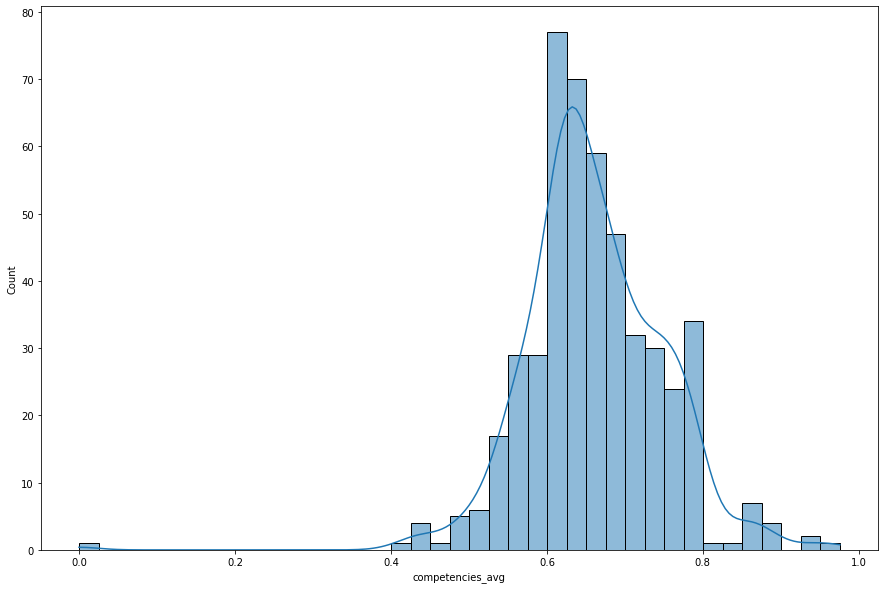

In [42]:
plt.figure(figsize=(15,10))
sns.histplot(data=df_pandas_objectives_performances, x="competencies_avg", kde=True)

<AxesSubplot:xlabel='competencies_avg', ylabel='objective_progress'>

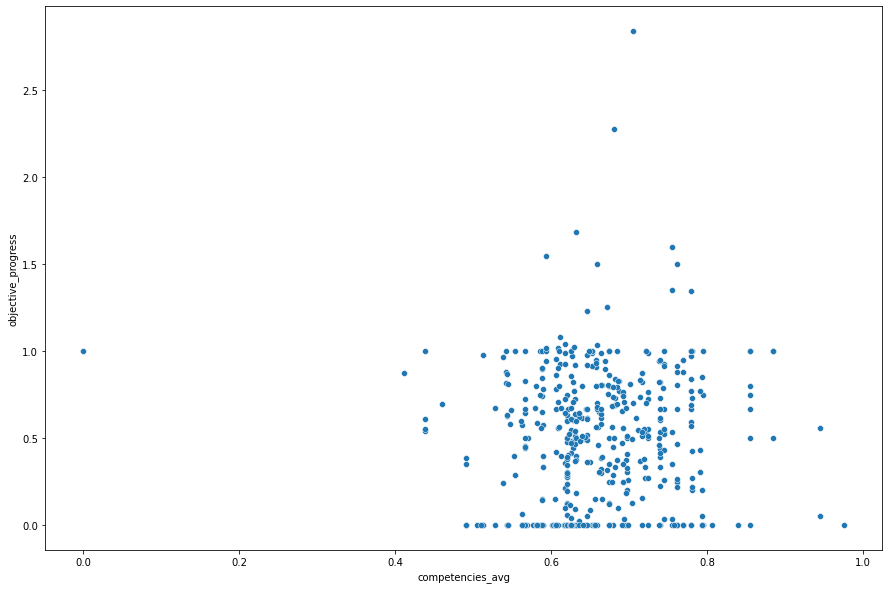

In [43]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=df_pandas_objectives_performances, x="competencies_avg", y="objective_progress")

##### Criando dataframe com os indicadores de desempenho de cada categoria dos objetivos

In [44]:
objectives = df_objectives.rdd \
    .map(lambda ob: (ob.id, ob.user_id, ob.progress)) \
    .distinct() \
    .collect()

categories = df_categories.rdd \
    .map(lambda c: (c.category_id, c.category_title)) \
    .distinct() \
    .collect()


data = []


def get_objective_related_users(objective_id, owner_id):
    related_users = [owner_id]

    objective_key_results_users_ids = df_key_results \
        .filter("objective_id == {}".format(objective_id)) \
        .rdd.map(lambda kr: kr.user_id) \
        .distinct() \
        .collect()

    related_users.extend(objective_key_results_users_ids)

    return related_users


for objective_id, owner_id, progress in objectives:
    related_users = get_objective_related_users(objective_id, owner_id)

    row_data = {
        'objective_id': objective_id,
        'progress': progress,
    }

    for category_id, category_title in categories:
        category_final_score_avg = df_categories \
            .filter(
                (pyf.col('user_id').isin(related_users)) & (pyf.col('category_id') == category_id)
            ) \
            .agg(pyf.avg(pyf.col("score"))) \
            .first()[0]

        row_data[category_title] = category_final_score_avg

    data.append(row_data)

##### Mostrando trecho do dataframe

In [45]:
df_pandas_objectives_with_categories_final_score = pd.DataFrame(data=data)
df_objectives_with_categories_final_score = spark.createDataFrame(df_pandas_objectives_with_categories_final_score)
df_objectives_with_categories_final_score.show()

+------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|objective_id|          progress|  Líder de Líderes|Gamers Soft Skills|       Lider de Si|Gamers Hard Skills|   Líder de Outros|  Learning Agility|           Valores|
+------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|          18|               1.0|               NaN|               NaN|               NaN|               NaN|               NaN|               NaN|               NaN|
|          20|               0.5| 0.670263761904762|               NaN|               NaN|               NaN|               NaN|0.6794783333333333|0.7715916666666667|
|          29|0.5459541666666666|               NaN|               NaN|0.6938356083333334|               NaN|               NaN|              0.74|0.6916666666666667

##### Descrição dos dados

In [46]:
df_objectives_with_categories_final_score.describe().show()

+-------+------------------+-------------------+------------------+------------------+-----------+------------------+---------------+-------------------+-------------------+
|summary|      objective_id|           progress|  Líder de Líderes|Gamers Soft Skills|Lider de Si|Gamers Hard Skills|Líder de Outros|   Learning Agility|            Valores|
+-------+------------------+-------------------+------------------+------------------+-----------+------------------+---------------+-------------------+-------------------+
|  count|               583|                583|               583|               583|        583|               583|            583|                583|                583|
|   mean| 483.2658662092624|0.46863296069009636|               NaN|               NaN|        NaN|               NaN|            NaN|                NaN|                NaN|
| stddev|269.25738459574865| 0.3899458408358532|               NaN|               NaN|        NaN|               NaN|            N

##### Distribuição do indicador de desempenho da cada categoria dos objetivos

<AxesSubplot:xlabel='Líder de Líderes', ylabel='Count'>

<AxesSubplot:xlabel='Gamers Soft Skills', ylabel='Count'>

<AxesSubplot:xlabel='Lider de Si', ylabel='Count'>

<AxesSubplot:xlabel='Gamers Hard Skills', ylabel='Count'>

<AxesSubplot:xlabel='Líder de Outros', ylabel='Count'>

<AxesSubplot:xlabel='Learning Agility', ylabel='Count'>

<AxesSubplot:xlabel='Valores', ylabel='Count'>

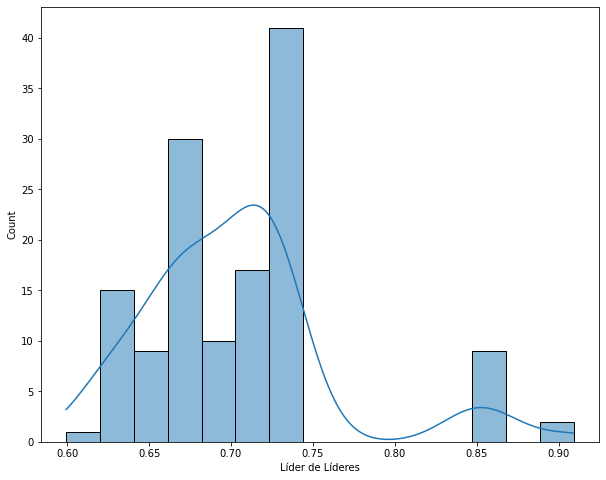

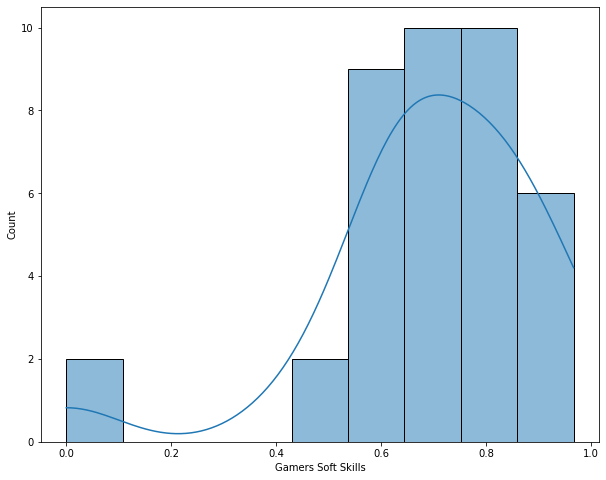

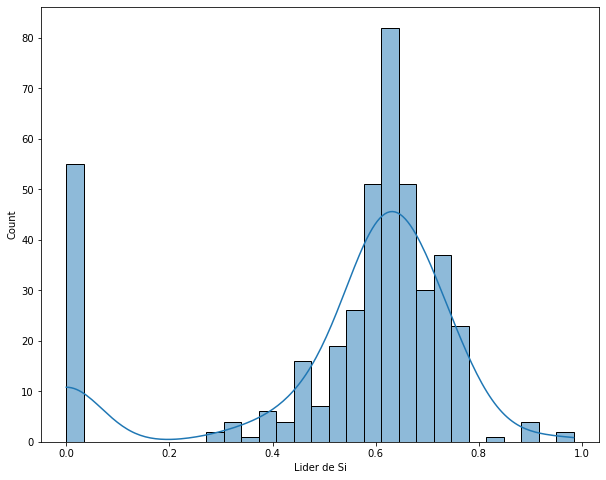

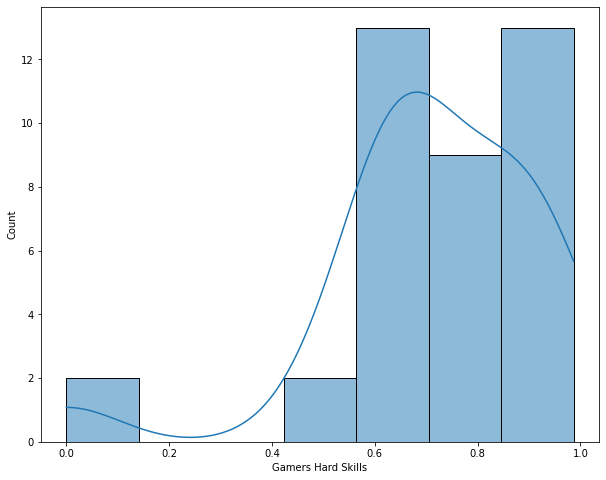

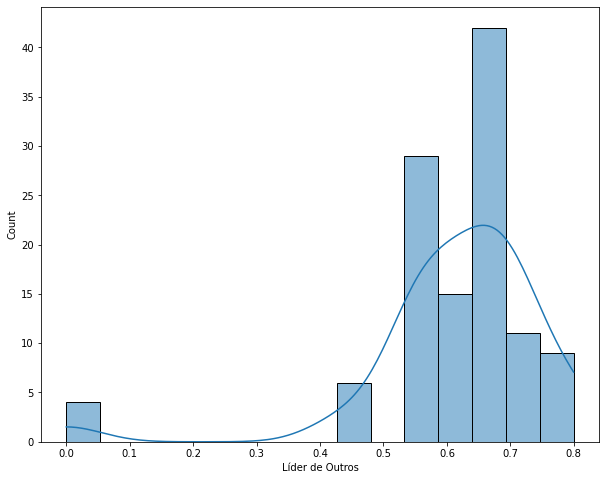

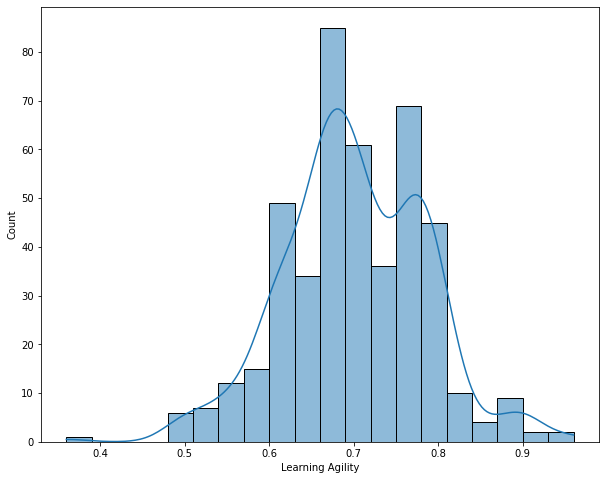

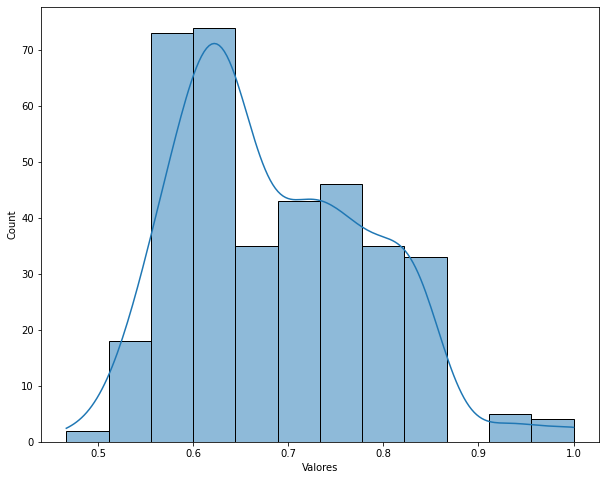

In [47]:
df = df_pandas_objectives_with_categories_final_score.drop(columns=['objective_id', 'progress'])
for _, category_title in categories:
    plt.figure(figsize=(10,8))
    g = sns.histplot(data=df, x=category_title, kde=True)
    display(g)

##### Pegando todos os usuários que possuem algum resultado de avaliação de desempenho, objetivo ou resultado chave

In [48]:
def get_users_ids_from_dataframe(df):
    return df.rdd \
        .map(lambda c: c.user_id) \
        .distinct() \
        .collect()


users_categories = get_users_ids_from_dataframe(df_categories)
users_subjects = get_users_ids_from_dataframe(df_subjects)
users_questions = get_users_ids_from_dataframe(df_questions)
all_evaluated_users = list(set(users_categories + users_subjects + users_questions))

    
users_objectives = get_users_ids_from_dataframe(df_objectives)
users_key_results = get_users_ids_from_dataframe(df_key_results)
all_users_with_some_objective_or_key_result = list(set(users_objectives + users_key_results))


##### Quantidade de usuários que possuem algum resultado de avaliação de desempenho mas não possui nenhum resultado chave ou objetivo atrelado a ele

In [49]:
acc = 0

for evaluated_user_id in all_evaluated_users:
    if evaluated_user_id not in all_users_with_some_objective_or_key_result:
        acc += 1

display(acc)

84

##### Quantidade de usuários que possuem algum objetivo ou resultado chave mas não possuem nenhum resultado de avaliação de desempenh atrelado a eles

In [50]:
acc = 0

for user_id in all_users_with_some_objective_or_key_result:
    if user_id not in all_evaluated_users:
        acc += 1

display(acc)

103

#### Encerra a sessão do Spark

In [51]:
# spark.stop()

22/01/18 16:15:28 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 14422082 ms exceeds timeout 120000 ms
22/01/18 16:15:28 WARN SparkContext: Killing executors is not supported by current scheduler.
